## Блок практики

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Загрузим датасет

data = pd.read_csv('proccessed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows7,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN
0,0.552153,0.530936,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,False,False,True,False,False,False,False,True,False,False
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,False,False,True,False,False,False,False,False,True,False
2,0.552153,0.530936,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,False,False,True,False,False,False,False,True,False,False
3,0.552153,0.530936,0.714442,7.0,0,53447.0,1.0,1.0,1,88,...,False,False,True,False,False,False,False,True,False,False
4,0.552153,0.530936,0.541395,7.0,0,53447.0,1.0,1.0,1,18,...,False,False,True,False,False,False,False,True,False,False


In [2]:
import pandas as pd

# Проверяем наличие нужного столбца
if 'HasDetections' not in data.columns:
    raise ValueError("Колонка 'HasDetections' не найдена в датасете. Проверьте структуру файла.")

# Посмотрим на начальное распределение классов
print("Изначальное распределение классов:")
print(data['HasDetections'].value_counts())

# Параметры для создания дисбаланса
target_class = 1  # Класс, который будем уменьшать
desired_ratio = 0.6  # Оставить только 10% записей target_class

# Разделяем данные на два класса
data_class_0 = data[data['HasDetections'] == 0]  # Все записи класса 0
data_class_1 = data[data['HasDetections'] == 1]  # Все записи класса 1

# Создаём дисбаланс: уменьшаем target_class
if target_class == 1:
    data_class_1 = data_class_1.sample(frac=desired_ratio, random_state=42)  # Оставляем 10% класса 1
else:
    data_class_0 = data_class_0.sample(frac=desired_ratio, random_state=42)  # Оставляем 10% класса 0

# Объединяем обратно
data_unbalanced = pd.concat([data_class_0, data_class_1])

# Проверяем новое распределение
print("Новое распределение классов:")
print(data_unbalanced['HasDetections'].value_counts())
data = data_unbalanced

Изначальное распределение классов:
HasDetections
1    100059
0     99940
Name: count, dtype: int64
Новое распределение классов:
HasDetections
0    99940
1    60035
Name: count, dtype: int64


## Убедимся в дисбалансе классов

In [3]:
data.HasDetections.value_counts()

HasDetections
0    99940
1    60035
Name: count, dtype: int64

## Разделим выборку на тренировочную и тестовую

In [4]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    shuffle=True, 
                                                    random_state=1)

## Задание 1
Обучите логистическую регрессию на тренировочной части данных. Используйте класс `LogisticRegression` из `sklearn.linear_model` с:
- `l2` регуляризацией
- коэффициентом регуляризации `C=0.01`

Масштабирование данных выполняется с помощью `StandardScaler`. Для объединения операций воспользуйтесь `Pipeline`. Переменная для хранения модели: `pipe`.

In [5]:
# Ваш код здесь
# Подсказка: Используйте Pipeline для объединения StandardScaler и LogisticRegression
# Пример:
# pipe = Pipeline([...])
# pipe.fit(X_train, y_train)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler',StandardScaler()),
                 ('LR',LogisticRegression())
                 ])
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('LR', LogisticRegression())])

In [6]:
y_pred = pipe.predict_proba(X_test)
y_pred

array([[0.61770825, 0.38229175],
       [0.5423553 , 0.4576447 ],
       [0.64840894, 0.35159106],
       ...,
       [0.54885885, 0.45114115],
       [0.68766776, 0.31233224],
       [0.5477619 , 0.4522381 ]])

/home/lapisya/Desktop/ml_test/myenv/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


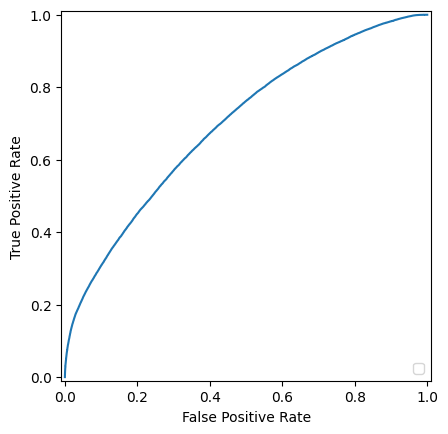

In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

### roc_curve вернет тюпл из наборов (FPR, TPR)
### для всевозможных порогов _

fpr, tpr, _ = roc_curve(y_train,pipe.predict_proba(X_train)[:, 1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Задание 2
Постройте ROC-кривую и вычислите ROC-AUC для трейна и теста. Для этого:
- Используйте `roc_curve` из `sklearn.metrics` для расчёта FPR, TPR.
- Воспользуйтесь методом `predict_proba` для получения вероятностей.
- Постройте кривую с помощью `RocCurveDisplay` или любого другого инструмента визуализации.
- Вычислите `ROC-AUC`, используя `auc`.

/home/lapisya/Desktop/ml_test/myenv/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


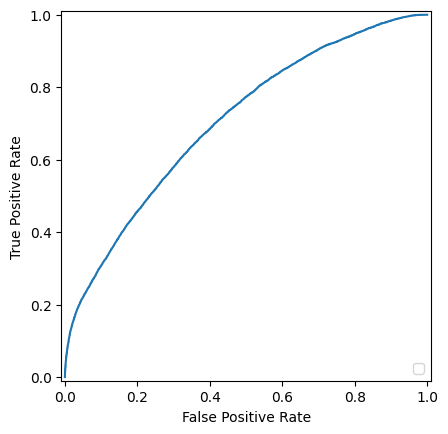

(np.float64(0.6987598695372033), np.float64(0.7052069645494258))

In [8]:
# Ваш код здесь
# Подсказка: Используйте roc_curve для получения FPR и TPR.
# Затем постройте график и посчитайте ROC-AUC.
from sklearn.metrics import roc_curve, auc,RocCurveDisplay

fpr_test,tpr_test,threshold = roc_curve(y_test,y_pred[:,1])

RocCurveDisplay(fpr=fpr_test,tpr=tpr_test).plot()
plt.show()
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc = auc(fpr,tpr)
roc_auc, roc_auc_test

## Задание 3
Постройте PR-кривую и вычислите PR-AUC для трейна и теста. Для этого:
- Используйте `precision_recall_curve` из `sklearn.metrics` для расчёта Precision, Recall.
- Постройте кривую с помощью `PrecisionRecallDisplay` или аналогичного инструмента.
- Вычислите PR-AUC с помощью `auc`.

np.float64(0.5999473943071095)

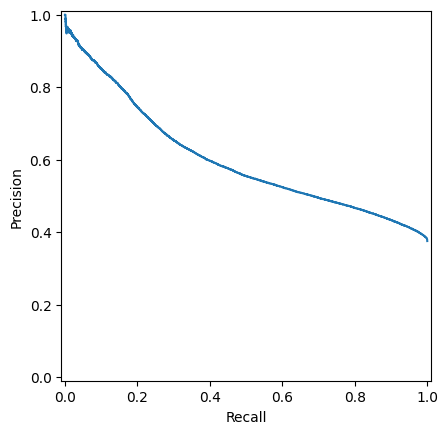

In [9]:
# Ваш код здесь
# Подсказка: Для Precision и Recall используйте precision_recall_curve. 
# Постройте график и посчитайте PR-AUC.
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, threshold_pr = precision_recall_curve(y_train, pipe.predict_proba(X_train)[:,1])
PrecisionRecallDisplay(precision=precision,recall=recall).plot()
auc(recall,precision)

## Задание 4
Постройте калибровочную кривую для тестовых данных. Сравните результат с калибровочной кривой для случайного классификатора. Для этого:
- Используйте `calibration_curve` из `sklearn.calibration` для расчёта кривой.
- Постройте график с реальными предсказаниями модели и случайными предсказаниями.

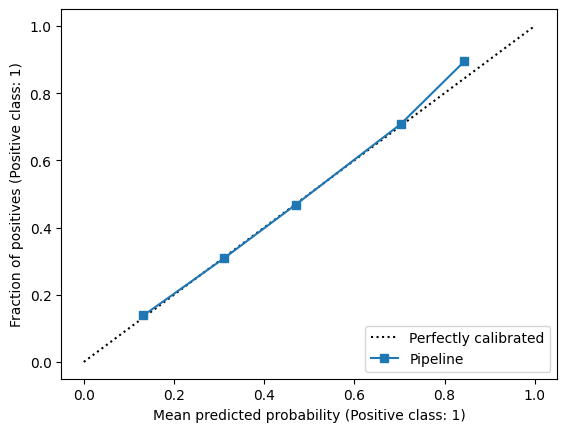

In [10]:
# Ваш код здесь
# Подсказка: Используйте calibration_curve для расчёта калибровочной кривой.
# Постройте кривые для модели и случайных предсказаний.
#что и стоило ожидать, из теоретических свойсв ЛогРега как раз-таки есть корректная оценка вероятностей!*
from sklearn.calibration import calibration_curve, CalibrationDisplay

CalibrationDisplay.from_estimator(pipe,X_test,y_test)

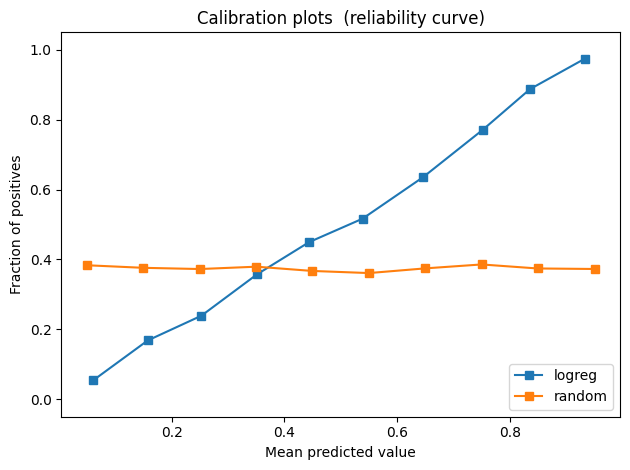

In [11]:
prob_pos = pipe.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()

In [12]:
data.to_csv('corrupted_processed_train.csv')